<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoders and Data Quality for Tabular Data**

This notebook searches the parameter space to create the best possible architecture for our autoencoder and saves the file into a Google Storage Bucket.

In [1]:
!rm -rf autoencoders_census
!git clone https://github.com/ipeirotis/autoencoders_census.git
%cd autoencoders_census

Cloning into 'autoencoders_census'...
remote: Enumerating objects: 522, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 522 (delta 95), reused 2 (delta 2), pack-reused 366
Receiving objects: 100% (522/522), 47.96 MiB | 27.92 MiB/s, done.
Resolving deltas: 100% (309/309), done.
/content/autoencoders_census


In [2]:
from google.colab import auth

# Login using the account that has access to the Google project
# in order to access the resources for the project
auth.authenticate_user()

In [3]:
!pip install -q import_ipynb keras-tuner
import import_ipynb
from pandas2vector import Table2Vector
from data_loader import DataLoader
from autoencoder import AutoencoderModel
from autoencoder import VariationalAutoencoderModel

importing Jupyter notebook from pandas2vector.ipynb
importing Jupyter notebook from data_loader.ipynb
importing Jupyter notebook from autoencoder.ipynb
Using TensorFlow backend


# Data Source

The used data stems from the Youth Risk Behavior Surveillance System by CDC (Centers for Disease Control and Prevention). It includes data on a set of surveys that track behaviors that can lead to poor health in students grades 9 through 12. [Here](https://www.cdc.gov/healthyyouth/data/yrbs/data.htm) is the link to the dataset.

Note: The dataset is updated every two years. We use the 2017 version of the national high school YRBS dataset.

## Libraries

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Load Original Dataset

In [5]:
# Data Source
data_loader = DataLoader()


In [6]:
project_data, variable_types  = data_loader.load_2017()

In [7]:
project_data.shape

(14765, 98)

# Transforming the original data set

In [8]:
# Data Transformation
vectorizer = Table2Vector(variable_types)


# Without indicator variables for missingness
vectorized_df = vectorizer.vectorize_table(project_data)

In [9]:
vectorized_df.shape

(14765, 609)

In [10]:
vectorizer.tabularize_vector(vectorized_df).shape

(14765, 98)

# Autoencoder training

## Hyperparameter search and model training

The training of an autoencoder model while effectively handling missing data with mask variables.

In [11]:
project_data.describe().T

,count,unique,top,freq
age,14765,8,16 years old,3688
sex,14765,3,Female,7526
grade,14765,5,9th,3921
Hispanic_or_Latino,14765,5,White,6261
race,14765,8,White,6261
...,...,...,...,...
weight_cat,14765,2,normal,13838
stheight_cat,14765,4,normal,12204
stweight_cat,14765,4,normal,12314
bmi_cat,14765,4,normal,12472


In [12]:
attr_cardinalities = list(project_data.describe().T['unique'].values)
print(attr_cardinalities)

[8, 3, 5, 5, 8, 3, 3, 5, 5, 5, 4, 5, 4, 6, 6, 7, 9, 6, 6, 6, 9, 9, 9, 3, 7, 7, 3, 3, 3, 3, 3, 6, 4, 3, 8, 8, 3, 8, 8, 8, 8, 8, 9, 9, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 4, 3, 3, 9, 8, 9, 4, 4, 9, 6, 5, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 8, 8, 7, 5, 4, 6, 4, 8, 8, 7, 8, 8, 4, 9, 7, 7, 3, 5, 2, 4, 4, 4, 3]


In [13]:
sum(attr_cardinalities)

609

In [ ]:
# Instantiate the class
model = AutoencoderModel(attr_cardinalities)
# Preprocess the data
X_train, X_test = model.split_train_test(vectorized_df)

# Define the search space

# how many times to run with the same configuration: offers better statistical significance
model.EXECUTIONS_PER_TRIAL=1

# how many runs over the training data: the more the better accuracy but takes time
model.EPOCHS=5

# how many different parameter configurations to try
model.MAX_TRIALS=25



In [ ]:
# Define the tuner
tuner = model.define_tuner()

# Perform hyperparameter search
tuner.search(X_train, X_train, epochs=model.EPOCHS,
             batch_size=64,
             validation_data=(X_test, X_test))

# Get the best hyperparameters and build the final model
best_hps = tuner.get_best_hyperparameters()[0]
final_model = model.build_autoencoder(best_hps)

Trial 25 Complete [00h 01m 19s]
val_loss: 4.327934265136719

Best val_loss So Far: 0.43019428849220276
Total elapsed time: 00h 32m 56s


In [ ]:
best_hps.values

{'learning_rate': 0.001,
 'encoder_units_1': 144,
 'encoder_l2_1': 0.0,
 'encoder_dropout_1': 0.1,
 'encoder_units_2': 16,
 'encoder_l2_2': 0.0,
 'encoder_dropout_2': 0.30000000000000004,
 'latent_space_dim': 6,
 'decoder_units_1': 112,
 'decoder_l2_1': 0.01,
 'decoder_dropout_1': 0.0,
 'decoder_units_2': 144,
 'decoder_l2_2': 0.001,
 'decoder_dropout_2': 0.2}

In [ ]:
# Train the final model
history = final_model.fit(X_train, X_train,
                           epochs=10*model.EPOCHS,
                           verbose=1,
                           validation_data=(X_test, X_test))

Epoch 1/50
370/370 [==============================] - 58s 44ms/step - loss: 0.7822 - val_loss: 0.5502
Epoch 2/50
370/370 [==============================] - 13s 36ms/step - loss: 0.5196 - val_loss: 0.4635
Epoch 3/50
370/370 [==============================] - 13s 36ms/step - loss: 0.4901 - val_loss: 0.4459
Epoch 4/50
370/370 [==============================] - 13s 36ms/step - loss: 0.4784 - val_loss: 0.4377
Epoch 5/50
370/370 [==============================] - 13s 35ms/step - loss: 0.4715 - val_loss: 0.4367
Epoch 6/50
370/370 [==============================] - 13s 36ms/step - loss: 0.4668 - val_loss: 0.4307
Epoch 7/50
370/370 [==============================] - 13s 35ms/step - loss: 0.4630 - val_loss: 0.4304
Epoch 8/50
370/370 [==============================] - 13s 35ms/step - loss: 0.4609 - val_loss: 0.4289
Epoch 9/50
370/370 [==============================] - 13s 35ms/step - loss: 0.4577 - val_loss: 0.4253
Epoch 10/50
370/370 [==============================] - 13s 36ms/step - loss: 0.455

Visualize the training and validation loss values over epochs.

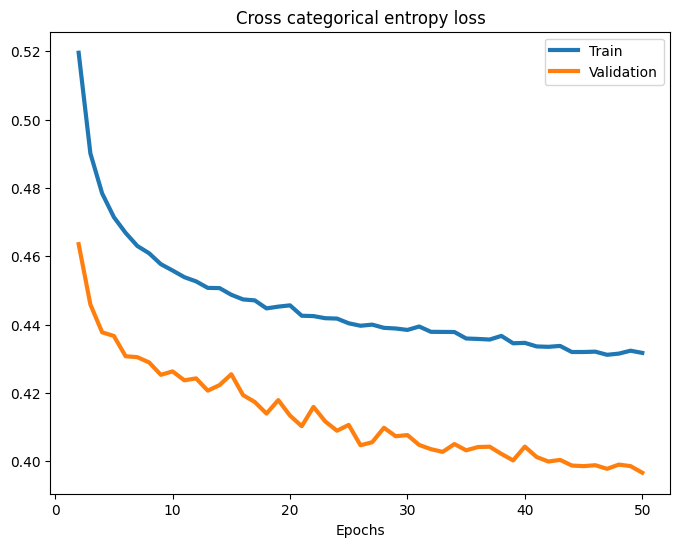

Training = 0.43170303106307983
Validation = 0.3966219127178192


In [ ]:
def model_analysis(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.title("Cross categorical entropy loss")
    sns.lineplot(x=epochs[1:], y=train_loss[1:], label="Train", linewidth=3)
    sns.lineplot(x=epochs[1:], y=val_loss[1:], label="Validation", linewidth=3)
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()

    print(f"Training = {(train_loss[-1])}")
    print(f"Validation = {(val_loss[-1])}")

model_analysis(history.history['loss'], history.history['val_loss'])

In [ ]:
import gcsfs
# Create a GCS filesystem object using your project ID
fs = gcsfs.GCSFileSystem(project='autoencoder_census')

# Save the model locally
model_filename = "best_parameters_autoencoder.keras"
final_model.save(model_filename)



# Define the path to the file on GCS
gcs_model_path = f"gs://autoencoder_census_models/{model_filename}"

# Open the local file in binary mode and upload its content to GCS
with open(model_filename, 'rb') as local_file:
    with fs.open(gcs_model_path, 'wb') as gcs_file:
        gcs_file.write(local_file.read())


In [ ]:


# Store the hyperparameters and evaluation metrics in a dictionary
hyperparameters_dict = {"params": best_hps.values,
                        "loss": history.history['loss'][-1],
                        "val_loss": history.history['val_loss'][-1]}

hyperparameters_dict

{'params': {'learning_rate': 0.001,
  'encoder_units_1': 144,
  'encoder_l2_1': 0.0,
  'encoder_dropout_1': 0.1,
  'encoder_units_2': 16,
  'encoder_l2_2': 0.0,
  'encoder_dropout_2': 0.30000000000000004,
  'latent_space_dim': 6,
  'decoder_units_1': 112,
  'decoder_l2_1': 0.01,
  'decoder_dropout_1': 0.0,
  'decoder_units_2': 144,
  'decoder_l2_2': 0.001,
  'decoder_dropout_2': 0.2},
 'loss': 0.43170303106307983,
 'val_loss': 0.3966219127178192}

Variational Autoencoder Training

In [14]:
model = VariationalAutoencoderModel(attr_cardinalities)
X_train, X_test = model.split_train_test(vectorized_df)
model.EXECUTIONS_PER_TRIAL=1
model.EPOCHS=5
model.MAX_TRIALS=25

In [15]:
tuner = model.define_tuner()

tuner.search(X_train, X_train, epochs=model.EPOCHS,
             batch_size=64,
             validation_data=(X_test, X_test))

best_hps = tuner.get_best_hyperparameters()[0]
final_model = model.build_autoencoder(best_hps)

Trial 25 Complete [00h 01m 15s]
val_loss: 15.384894371032715

Best val_loss So Far: 15.130912780761719
Total elapsed time: 00h 29m 22s


In [16]:
best_hps.values

{'learning_rate': 0.001,
 'encoder_units_1': 160,
 'encoder_l2_1': 0.0,
 'encoder_dropout_1': 0.1,
 'encoder_units_2': 16,
 'encoder_l2_2': 0.0,
 'encoder_dropout_2': 0.0,
 'latent_space_dim': 14,
 'decoder_units_1': 128,
 'decoder_l2_1': 0.0,
 'decoder_dropout_1': 0.0,
 'decoder_units_2': 192,
 'decoder_l2_2': 0.0,
 'decoder_dropout_2': 0.0}

In [17]:
history = final_model.fit(X_train, X_train,
                           epochs=10*model.EPOCHS,
                           verbose=1,
                           validation_data=(X_test, X_test))

Epoch 1/50
370/370 [==============================] - 46s 41ms/step - loss: 16.6347 - val_loss: 15.1435
Epoch 2/50
370/370 [==============================] - 13s 34ms/step - loss: 15.1614 - val_loss: 15.1572
Epoch 3/50
370/370 [==============================] - 13s 34ms/step - loss: 15.1390 - val_loss: 15.1537
Epoch 4/50
370/370 [==============================] - 13s 34ms/step - loss: 15.1349 - val_loss: 15.1823
Epoch 5/50
370/370 [==============================] - 13s 34ms/step - loss: 15.1337 - val_loss: 15.1377
Epoch 6/50
370/370 [==============================] - 13s 34ms/step - loss: 15.1292 - val_loss: 15.1739
Epoch 7/50
370/370 [==============================] - 13s 34ms/step - loss: 15.1318 - val_loss: 15.1593
Epoch 8/50
370/370 [==============================] - 13s 34ms/step - loss: 15.1298 - val_loss: 15.1528
Epoch 9/50
370/370 [==============================] - 13s 34ms/step - loss: 15.1295 - val_loss: 15.1540
Epoch 10/50
370/370 [==============================] - 13s 34ms/

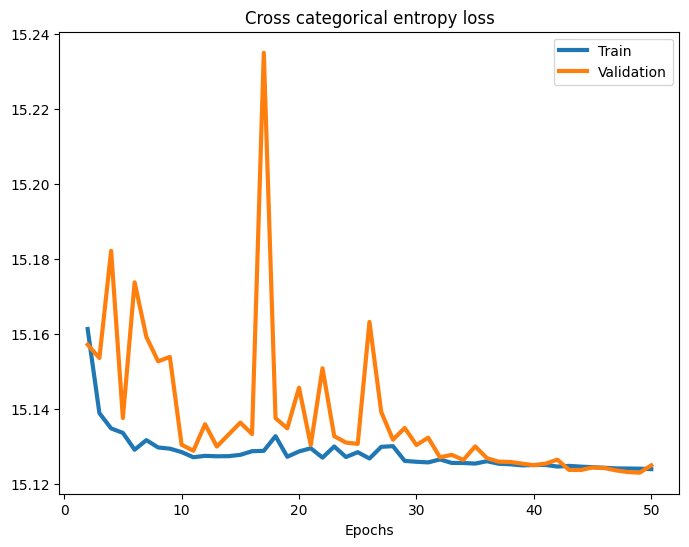

Training = 15.124039649963379
Validation = 15.12504768371582


In [18]:
def model_analysis(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.title("Cross categorical entropy loss")
    sns.lineplot(x=epochs[1:], y=train_loss[1:], label="Train", linewidth=3)
    sns.lineplot(x=epochs[1:], y=val_loss[1:], label="Validation", linewidth=3)
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()

    print(f"Training = {(train_loss[-1])}")
    print(f"Validation = {(val_loss[-1])}")

model_analysis(history.history['loss'], history.history['val_loss'])

In [19]:
hyperparameters_dict = {"params": best_hps.values,
                        "loss": history.history['loss'][-1],
                        "val_loss": history.history['val_loss'][-1]}

hyperparameters_dict

{'params': {'learning_rate': 0.001,
  'encoder_units_1': 160,
  'encoder_l2_1': 0.0,
  'encoder_dropout_1': 0.1,
  'encoder_units_2': 16,
  'encoder_l2_2': 0.0,
  'encoder_dropout_2': 0.0,
  'latent_space_dim': 14,
  'decoder_units_1': 128,
  'decoder_l2_1': 0.0,
  'decoder_dropout_1': 0.0,
  'decoder_units_2': 192,
  'decoder_l2_2': 0.0,
  'decoder_dropout_2': 0.0},
 'loss': 15.124039649963379,
 'val_loss': 15.12504768371582}